In [1]:
import pyspark as ps
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
import scipy.stats as stats

In [6]:
df = pd.read_csv('data/cleaned_data.csv',index_col=[0])

In [10]:
df

,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,"Frodeno, Jan",DEU,Male,MPRO,47.516667,256.033333,162.716667,471.216667,1,1,1,1.966667,2.983333
1,"O'donnell, Tim",USA,Male,MPRO,47.633333,258.183333,169.750000,479.683333,2,2,2,2.016667,2.100000
2,"Kienle, Sebastian",DEU,Male,MPRO,52.283333,255.066667,169.933333,482.066667,3,3,3,2.200000,2.583333
3,"Hoffman, Ben",USA,Male,MPRO,51.016667,264.016667,163.133333,482.866667,4,4,4,2.416667,2.283333
4,"Wurf, Cameron",AUS,Male,MPRO,52.416667,254.733333,175.050000,486.683333,5,5,5,2.116667,2.366667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,"Beavers, Cathy",USA,Female,F65-69,105.500000,505.016667,378.866667,1010.050000,26,609,2262,10.416667,10.250000
2254,"Whitehouse, Paul",USA,Male,M70-74,126.016667,471.333333,389.566667,1010.066667,28,1654,2263,11.816667,11.333333
2255,"Svoboda-vasquez, Hanna",DEU,Female,F50-54,89.550000,496.450000,407.700000,1011.050000,66,610,2264,9.783333,7.566667
2256,"Piasentini, Edgardo",ARG,Male,M65-69,102.450000,462.150000,433.816667,1013.350000,50,1655,2265,6.283333,8.650000


# Separating DF to Pros and Amateurs by Gender

In [12]:
male_results = df[df['Gender'] == 'Male']
male_pro = male_results[male_results['Division'] == 'MPRO']
male_agegroups = male_results[male_results['Division'] != 'MPRO']

In [13]:
fem_results = df[df['Gender'] == 'Female']
fem_pro = fem_results[fem_results['Division'] == 'FPRO']
fem_agegroups = fem_results[fem_results['Division'] != 'FPRO']

# Separating DF by Division

In [ ]:
male_div_list = male_agegroups.Division.unique()
fem_div_list = fem_agegroups.Division.unique()
fem_div_list, male_div_list

# Plotting scatters of pro event times by gender

In [6]:
def plot_genders_rank(sport, df1=fem_pro, df2=male_pro):
    xf = df1['Division Rank']
    yf = df1[sport]
    xm = df2['Division Rank']
    ym = df2[sport]

    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(xf, yf, c='pink')
    ax.scatter(xm, ym)

    ax.set_title(f'{sport} Times by Ranking')
    ax.set_xlabel('Division Rank')
    ax.set_ylabel(f'{sport} Time (minutes)')

    ax.axvline(1, c='pink', linestyle="--")
    ax.axvline(xf.max(), c='pink', linestyle="--")
    ax.axvline(1, c='grey', linestyle="--")
    ax.axvline(xm.max(), c='grey', linestyle="--")
    return fig, ax

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f314fafc2e0>)

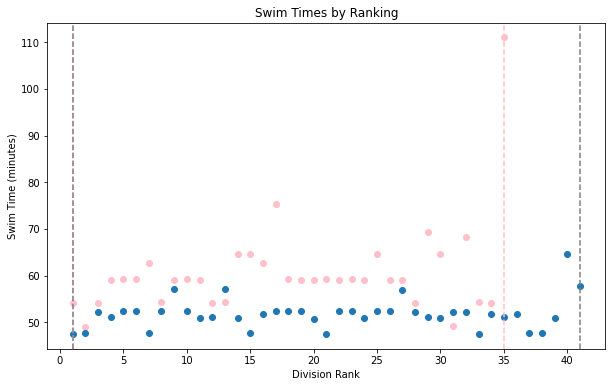

In [7]:
plot_genders_rank('Swim')

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f314da872e0>)

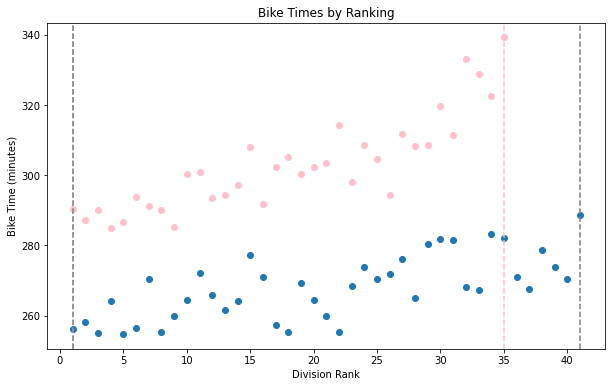

In [8]:
plot_genders_rank('Bike')

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f317436c070>)

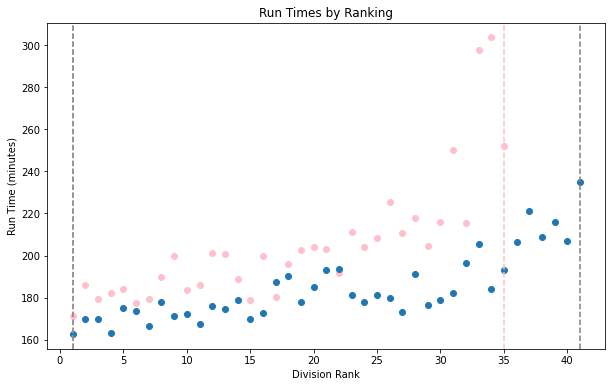

In [9]:
plot_genders_rank('Run')

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f314d9a74c0>)

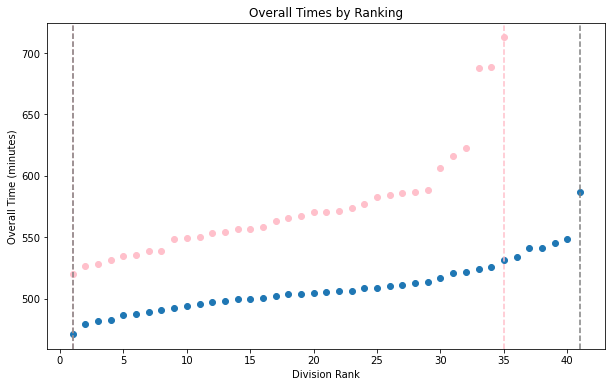

In [10]:
plot_genders_rank('Overall')

# Plotting scatters of amateur event times by gender

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f314d913370>)

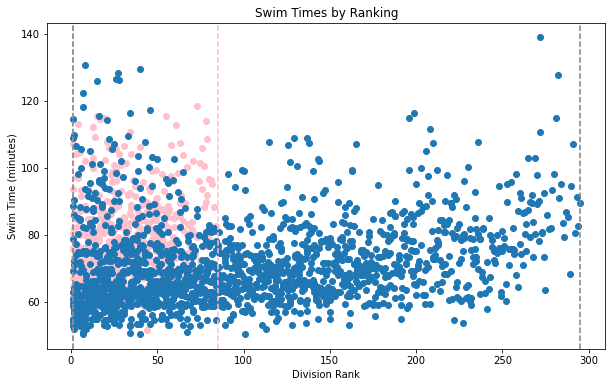

In [11]:
plot_genders_rank('Swim', df1=fem_agegroups, df2=male_agegroups)

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f314d870e50>)

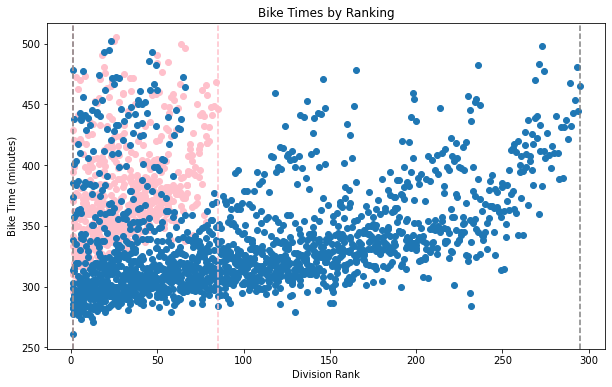

In [12]:
plot_genders_rank('Bike', df1=fem_agegroups, df2=male_agegroups)

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f314d8570a0>)

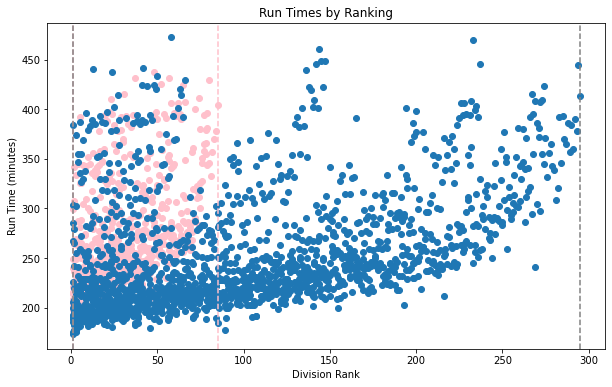

In [13]:
plot_genders_rank('Run', df1=fem_agegroups, df2=male_agegroups)

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3147f9baf0>)

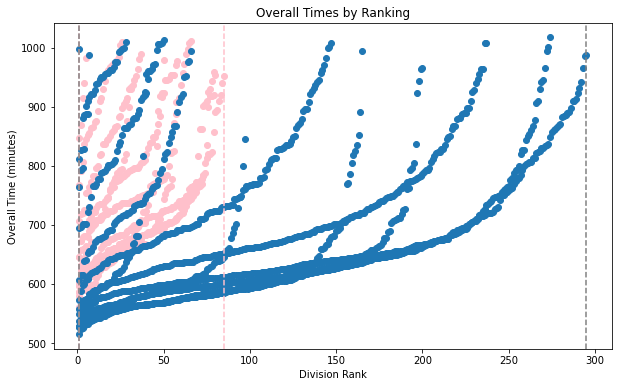

In [14]:
plot_genders_rank('Overall', df1=fem_agegroups, df2=male_agegroups)

# Do men race faster on average than women?

Based on these scatter plots, it certainly seems so. I will conduct a two-sample, unpaired T-Test since both gender's event times are independent of each other. This test states a null hypothesis and alternative hypothesis as follows:

Null hypothesis: men and women mean overall times are equal.

Alternative hypothesis: men and women mean overal times are not equal, or one of them races faster on average than the other.

In [15]:
from scipy.stats import ttest_ind

In [16]:
t_statistic, pvalue = ttest_ind(male_pro['Overall'], fem_pro['Overall'], equal_var=False)
print(f'Pro t-test statistic: {round(t_statistic,2)}')
print(f'Pro p-value: {pvalue}')

Pro t-test statistic: -7.76
Pro p-value: 5.156855215220441e-10


The large, negative T-Test Statistic value (-7.76) means there is a very big difference between the gender's mean overall times. The very small P-value allows us to reject the null hypothesis in favor of the alternative hypothesis. Therefore we can reason that pro male triathletes, on average, race faster than pro women triathletes. We can run a similar test on the amateur gender groups:

In [17]:
t_statistic, pvalue = ttest_ind(male_agegroups['Overall'], fem_agegroups['Overall'], equal_var=False)
print(f'Amateur t-test statistic: {round(t_statistic,2)}')
print(f'Amateur p-value: {pvalue}')

Amateur t-test statistic: -13.63
Amateur p-value: 3.889330523969423e-39


The amateur gender race times give us stronger reason to reject the null hypothesis and state that on average, male amateur triathletes compete faster than female amateur triathletes.

# What correlation do event times have with ranking?

In [18]:
import seaborn as sns

## Normalizing data

In [19]:
df['Bool_Gender'] = df['Gender'] == "Female" # If you're female, Division Rank goes down
df['Bool_Gender'].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
2251    1
2252    0
2253    1
2254    0
2255    0
Name: Bool_Gender, Length: 2256, dtype: int64

In [20]:
heatmap_cols = ['Swim', 'T1', 'Bike', 'T2', 'Run', 'Overall', 'Bool_Gender', 'Division Rank']

In [21]:
heat_df = df[heatmap_cols]

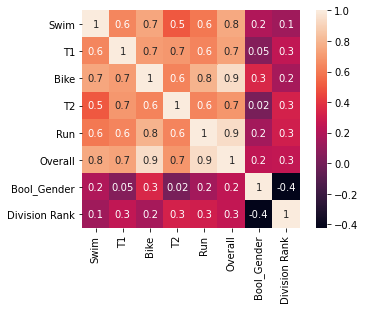

In [22]:
sns.heatmap(heat_df.corr(), annot = True, fmt='.1g', square=True)


Based on the correlation map, we can see that all three events: Swim, Bike, & Run have high correlations with the Overall Time but Swim is slightly less correlated than the other two sports. Run has the greatest correlation of the three events with division rank. Transition times, T1 and T2 have very high correlations with Division Rank! 

I'd like to take a look at just the pros.

<ipython-input-23-d15dfb87c2b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_pros['Bool_Gender'] = (df['Division'] == "FPRO")


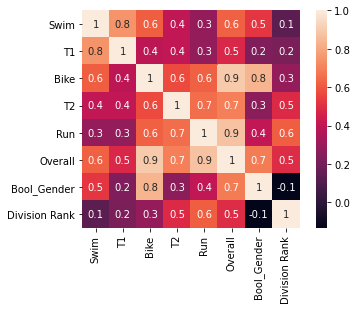

In [23]:
pro_mask = (df['Division'] == 'MPRO') | (df['Division'] == 'FPRO')
heat_pros = df[pro_mask]
heat_pros['Bool_Gender'] = (df['Division'] == "FPRO")
heat_pros['Bool_Gender'].astype(int)
plot = heat_pros[heatmap_cols]
sns.heatmap(plot.corr(), annot = True, fmt='.1g', square=True)

T2 and run times have the greatest correlations of all the events with how pros rank. This is important to note: pro athletes need to practice their transition from bike to run and need to perform best in running to rank higher. 

In the amateur heatmap, we can see swim has the lowest correlation with ranking than the other event times. However both transitions for amateurs are very important to practice as they hold the same correlation as the run event with rank.

Both heatmaps include a Bool_Gender column where female athletes result in True and male in False. the negative correlation we see in both heatmaps supports evidence from the previous scatter plots and t-tests that female athletes race slower and rank lower than male athletes, on average.

# How many amateurs are racing like pros?

I'm looking to bootstrap the lower 90th percentile of pro event times, and compare those to the bootstrapped 10th percentile of amateur event times.

i.e. if you race x or faster => pro

In [102]:
def times(df, sport):
    '''
    Returns an array of randomly chosen times according to the sport specified.
    
    Parameters:
    df: dataFrame pulling from
    sport: string: 'Swim', 'Bike', 'Run', or 'Overall'
    
    Returns:
    np.array of length 2434, with time entries in minutes
    '''
    l = df[sport]
    return np.random.choice(df[sport], size=len(l), replace=True)

In [103]:
def bootstrap_statistic(df, sport, samples, statistic):
    '''
    Returns an array of bootstrapped statistics
    
    Parameters:
    df: dataFrame pulling from
    sport: string: 'Swim', 'Bike', 'Run', or 'Overall'
    samples: int: # of samples desired
    statistic: string: statistic to calculate on sample i.e. np.median, np.var, np.std
    '''
    statistics = []
    for i in range(samples):
            samp = times(df, sport)
            statistics.append(statistic(samp))
    return statistics

In [104]:
def bootstrap_percentile(df, sport, samples, percent, statistic=np.percentile):
    '''
    Returns an array of bootstrapped percentiles
    
    Parameters:
    df: dataFrame pulling from
    sport: string: 'Swim', 'Bike', 'Run', or 'Overall'
    samples: int: # of samples desired
    statistic: np.percentile
    '''
    statistics = []
    for i in range(samples):
        samp = times(df, sport)
        statistics.append(statistic(samp, percent))
    return statistics

# Let's look at the "slower" pros:

In [109]:
def plot_pro_90(sport, df1=fem_pro, df2=male_pro):
    # Generate bootstrap 90th percentiles
    fem_90p = bootstrap_percentile(df1, sport, 1000, 90)
    male_90p = bootstrap_percentile(df2, sport, 1000, 90)
    
    # Say it with confidence
    left_f90p = np.percentile(fem_90p, 2.5)
    right_f90p = np.percentile(fem_90p, 97.5)

    left_m90p = np.percentile(male_90p, 2.5)
    right_m90p = np.percentile(male_90p, 97.5)
    
    # Plot it
    fig, ax = plt.subplots(1, figsize=(12,4))
    ax.hist(fem_90p, bins=50, density=True, color='pink', alpha=0.8, label=f'Female Pro {sport} 90th Percentile')
    ax.hist(male_90p, bins=50, density=True, color='b', alpha=0.7, label=f'Male Pro {sport} 90th Percentile')
    ax.legend()

    ax.set_title(f'Pro {sport} 90th Percentiles', fontsize=20)
    ax.set_xlabel(f'{sport} Time (minutes)', fontsize=15)
    ax.set_ylabel(f'Frequency of Bootstrapped 90th Percentiles', fontsize=10)
    
    ax.axvline(left_f90p, c='pink', linestyle="--")
    ax.axvline(right_f90p, c='pink', linestyle="--")
    ax.axvline(left_m90p, c='grey', linestyle="--")
    ax.axvline(right_m90p, c='grey', linestyle="--")
    
    print(f'Female Pro {sport} Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [{round(left_f90p, 2)}, {round(right_f90p,2)}]')
    print(f'Male Pro {sport} Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [{round(left_m90p, 2)}, {round(right_m90p,2)}]')

    return fig, ax

Female Pro Swim Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [62.75, 75.4]
Male Pro Swim Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [52.38, 57.83]


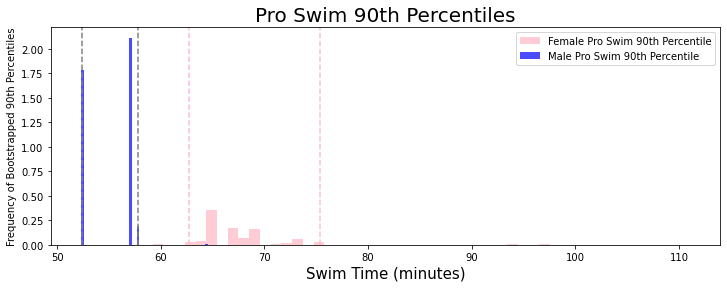

In [111]:
plot_pro_90('Swim')


In effort to answer the question, how fast do you need to swim to be considered a pro? We can see our 95% confidence interval for the 10th percentile of Female and Male Pro swim times. Therefore, if you swim in, or faster than this 10th percentile, I am 95% confident you are considered a pro swimming triathlete!

Female Pro Bike Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [308.73, 333.25]
Male Pro Bike Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [273.95, 283.17]


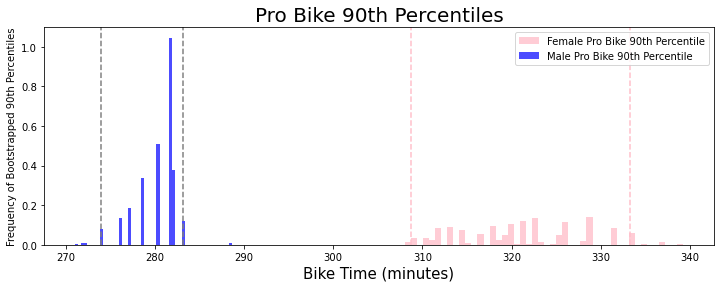

In [112]:
plot_pro_90('Bike')


Female Pro Run Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [211.4, 297.6]
Male Pro Run Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [193.28, 221.37]


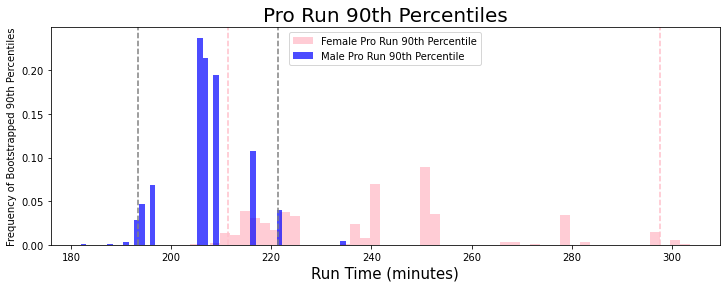

In [113]:
plot_pro_90('Run')


Something to keep in mind is that to be considered pro, you would need to compete in this percentile range (or faster) and have done all triathlon activities in the same order: swim-bike-run.

Female Pro Overall Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [585.87, 688.37]
Male Pro Overall Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [521.32, 548.9]


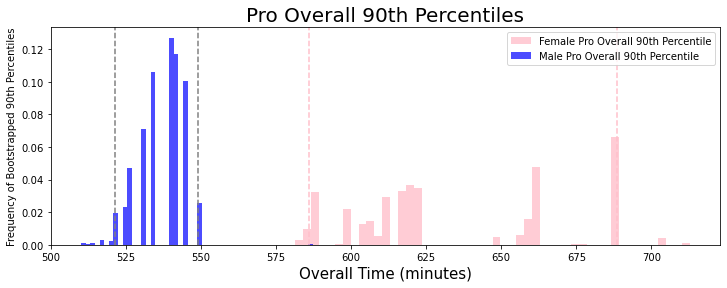

In [114]:
plot_pro_90('Overall')


# Let's look at the amateur times with the pro times 95% confidence intervals

In [115]:
def plot_amateur_proci(sport, df1=fem_agegroups, df2=male_agegroups, df3=fem_pro, df4=male_pro):
    f_agegroups_ = df1[sport]
    m_agegroups_ = df2[sport]

    # Generate pro bootstrap 90th percentiles
    fem_90p = bootstrap_percentile(df3, sport, 1000, 90)
    male_90p = bootstrap_percentile(df4, sport, 1000, 90)
    
    # Say it with confidence
    left_f90p = np.percentile(fem_90p, 2.5)
    right_f90p = np.percentile(fem_90p, 97.5)

    left_m90p = np.percentile(male_90p, 2.5)
    right_m90p = np.percentile(male_90p, 97.5)
    
    # Plot it
    fig, ax = plt.subplots(1, figsize=(12,4))
    
    ax.hist(m_agegroups_, bins=100, density=True, color='grey', alpha=0.75, label=f'Male Amateur {sport} Times')
    ax.hist(f_agegroups_, bins=100, density=True, color='pink', alpha=0.75, label=f'Female Amateur {sport} Times')
    ax.axvline(left_f90p, c='red', linestyle="--", label='Female Pro 90 Percentile')
    ax.axvline(right_f90p, c='red', linestyle="--")
    ax.axvline(left_m90p, c='black', linestyle="--", label='Male Pro 90 Percentile')
    ax.axvline(right_m90p, c='black', linestyle="--")
    ax.legend()

    ax.set_title(f'How do Amateurs Compare to the Pro {sport} 90th Percentile?', fontsize=20)
    ax.set_xlabel(f'{sport} Time (minutes)', fontsize=15)
    ax.set_ylabel(f'Frequency', fontsize=10)
    
    m_ = m_agegroups_[m_agegroups_ <= right_m90p]
    f_ = f_agegroups_[f_agegroups_ <= right_f90p]
    mam_pros_ = round((len(m_) / len(m_agegroups_))*100, 2)
    fam_pros_ = round((len(f_) / len(f_agegroups_))*100, 2)
    print(f'Percent of male amateurs who {sport} like pros: {mam_pros_}%')
    print(f'Percent of female amateurs who {sport} like pros: {fam_pros_}%')

    return fig, ax

Percent of male amateurs who Swim like pros: 8.28%
Percent of female amateurs who Swim like pros: 48.52%


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f31468aafd0>)

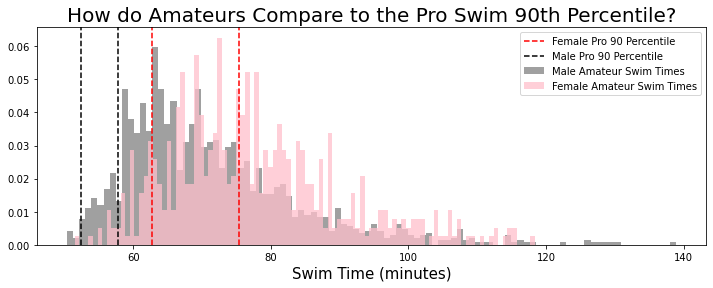

In [33]:
plot_amateur_proci('Swim')


Percent of male amateurs who Bike like pros: 1.74%
Percent of female amateurs who Bike like pros: 11.69%


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f314608da60>)

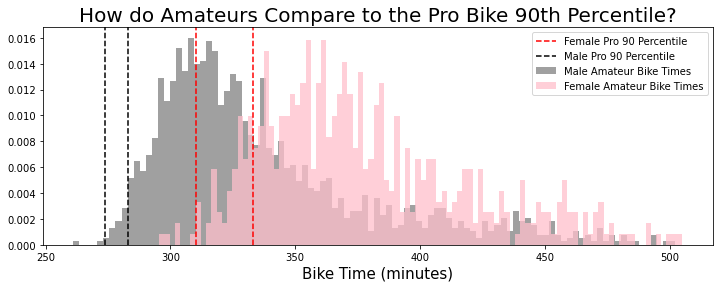

In [34]:
plot_amateur_proci('Bike')

Percent of male amateurs who Run like pros: 37.09%
Percent of female amateurs who Run like pros: 72.43%


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3145deee80>)

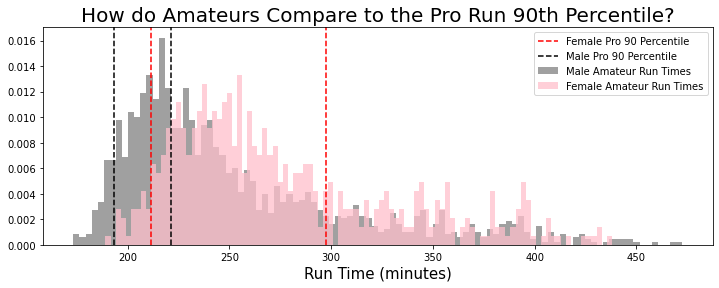

In [35]:
plot_amateur_proci('Run')

We can see from our original female pro run times, that 3-4 female pro runners were much slower than the majority of the female pro runners, bringing their 90th percentile further right. Which is why the percent of female amateurs who run like these pros is so high.

Percent of male amateurs who Overall like pros: 2.74%
Percent of female amateurs who Overall like pros: 36.47%


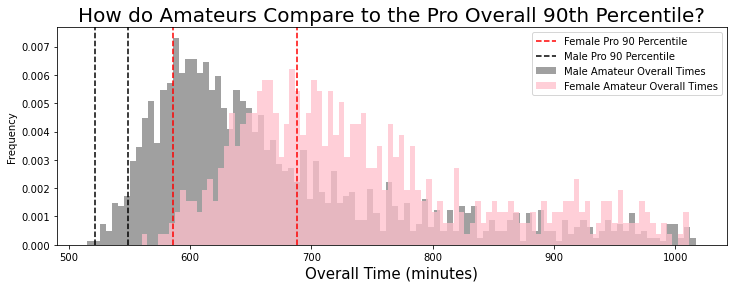

In [116]:
plot_amateur_proci('Overall')
plt.savefig('amateursoverallpro90th.png', bbox_inches='tight')

# Better: Bootstrap 10th percentile of amateur times and compare to pro's 90th percentile

In [122]:
def plot_cis(sport, df1=fem_agegroups, df2=male_agegroups, df3=fem_pro, df4=male_pro):    
    # Bootstrap amateur 10th percentiles
    fem_10 = bootstrap_percentile(df1, sport, 1000, 10)
    male_10 = bootstrap_percentile(df2, sport, 1000, 10)
    
    # Say it with confidence
    left_f10 = np.percentile(fem_10, 2.5)
    right_f10 = np.percentile(fem_10, 97.5)
    left_m10 = np.percentile(male_10, 2.5)
    right_m10 = np.percentile(male_10, 97.5)
    
    # Generate pro bootstrap 90th percentiles
    fem_90 = bootstrap_percentile(df3, sport, 1000, 90)
    male_90 = bootstrap_percentile(df4, sport, 1000, 90)
    
    # Say it with confidence
    left_f90 = np.percentile(fem_90, 2.5)
    right_f90 = np.percentile(fem_90, 97.5)
    left_m90 = np.percentile(male_90, 2.5)
    right_m90 = np.percentile(male_90, 97.5)
    
    # Plot it
    fig, ax = plt.subplots(1, figsize=(12,4))
    
    ax.hist(male_10, bins=100, density=True, color='grey', alpha=0.75, label=f'Male Amateur {sport} 10 Percentiles')
    ax.hist(fem_10, bins=100, density=True, color='pink', alpha=0.75, label=f'Female Amateur {sport} 10 Percentiles')
    ax.axvline(left_f90, c='red', linestyle="--", label='Female Pro 90 Percentile')
    ax.axvline(right_f90, c='red', linestyle="--")
    ax.axvline(left_m90, c='black', linestyle="--", label='Male Pro 90 Percentile')
    ax.axvline(right_m90, c='black', linestyle="--")
    ax.legend()

    ax.set_title(f'How does the {sport} Amateur 10th Percentile Compare to the Pro 90th Percentile?', fontsize=20)
    ax.set_xlabel(f'{sport} Time (minutes)', fontsize=15)
    ax.set_ylabel('Frequency', fontsize=15)
    return fig, ax

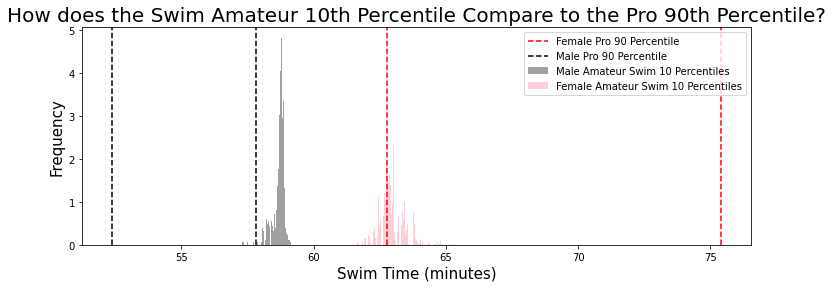

In [124]:
plot_cis('Swim')


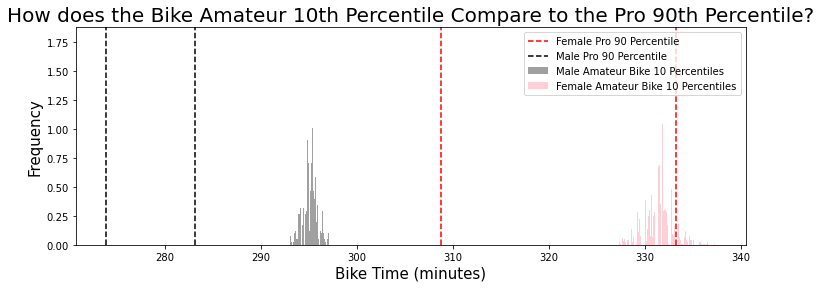

In [125]:
plot_cis('Bike')


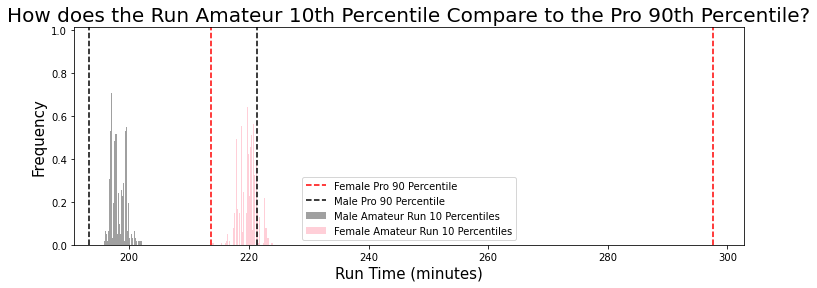

In [126]:
plot_cis('Run')


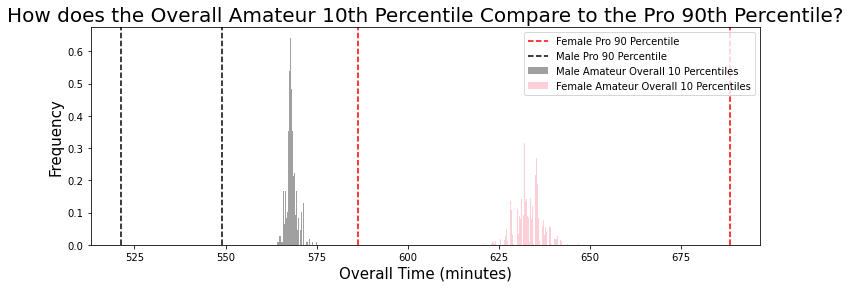

In [127]:
plot_cis('Overall')


This shows me I need to go back and clean out the female pro that is weighing down the values.

# Just who are these fast amateurs?

In [44]:
# Generate pro bootstrap 90th percentiles
fem_90p = bootstrap_percentile(fem_pro, 'Overall', 1000, 90)
male_90p = bootstrap_percentile(male_pro, 'Overall', 1000, 90)
    
# Say it with confidence
left_f90p = np.percentile(fem_90p, 2.5)
right_f90p = np.percentile(fem_90p, 97.5)

left_m90p = np.percentile(male_90p, 2.5)
right_m90p = np.percentile(male_90p, 97.5)

m = male_agegroups[male_agegroups.Overall <= right_m90p]
f = fem_agegroups[fem_agegroups.Overall <= right_f90p]
sponsor_these_men = m.sort_values('Overall')['Name'].tolist()
sponsor_these_women = f.sort_values('Overall')['Name'].tolist()

print(f'Best Male Amateurs:')
print(' ')
for i in range(len(sponsor_these_men)):
    print(f'{i} {sponsor_these_men[i]}')
print(' ')
print(f'Best Female Amateurs:')
print(' ')
for i in range(int(len(sponsor_these_women)/5)):
    print(f'{i} {sponsor_these_women[i]}')

Best Male Amateurs:
 
0 Marques, Sergio
1 Dels, Christopher
2 Geldenhuys, Donovan
3 Caceres lopez, Ivan
4 Tomasz, Aaron
5 Vinokurov, Alexandre
6 Picard, Raynard
7 Eddy, Neil
8 Giuliano, Ryan
9 De korver, Derk
10 Perez garcia, Javier
11 Herber, Philipp
12 Wies, Sven
13 Winkler, Benjamin
14 Sorensen, Carsten Demant
15 Enzenberger, Georg
16 Gleeson, Dylan
17 Hauwert, Levi
18 Eccleston, Lewis
19 Jackson, Steve
20 Perche, Antoine
21 Schmidbauer, Florian
22 Galindez, Oscar
23 Madsen, Jesper Sundstrup
24 Godart, Olivier
25 Vandenbroele, Niels
26 Storzer, Christian
27 Li, Peng Cheng
28 Gohner, Michael Tobias
29 Fogarty, Brian William
30 Takenaka, Alexandre
31 Mattner, Christoph
32 Malone, Matthew
33 Scheiderbauer, Jorg
34 Elliott, Thomas
35 Williams, Brice
36 Perget, Mathieu
37 Seewald, Jan Simon
38 Changeon, Gwenael
39 Schifferle, Mike
40 Kriszeleit, Leon
41 Uribe, Nicolas
42 Pellew, Mark
43 Palm-henriksen, Gustav
 
Best Female Amateurs:
 
0 Purbrook, Ruth
1 Schut, Kirsten
2 Van heerden, Nati

# Next compare event times to athlete's overall rank

To better see the event time's weight in their correlation with athlete's Overall Rank, I will standardize the timed event columns and plot them against Overall Rank!

Notes:

Athletes in 10 percentile Swim, also perform in 10 percentile Bike, or Run or Overall.
H0: 10% Swim => no better in Overall
    10% Swim - A
    90% Swim - B
Ha: 10% Swim == 10% other events

Standardized MA: standardization - subtract mean from ea. swim row, then divide by std dev
    Do this for all 'time' columns to be able to compare them
    This would change columns to non-dimensional

Bootstrap *mean* times 
Man Whitney U test: non-parametric version of the t-test

Adv.
Are countries surrounded by more water, producing athletes in 10% Swim?


In [ ]:
# plt.savefig('amateur10thoverallpro90th.png')

In [35]:
# Standardize event time columns by subtracting mean and dividing by standard deviation:
df['Norm_Swim'] = ( df['Swim'] - np.mean(df['Swim']) ) / np.std(df['Swim'])
df['Norm_Bike'] = ( df['Bike'] - np.mean(df['Bike']) ) / np.std(df['Bike'])
df['Norm_Run'] = ( df['Run'] - np.mean(df['Run']) ) / np.std(df['Run'])
df['Norm_T1'] = ( df['T1'] - np.mean(df['T1']) ) / np.std(df['T1'])
df['Norm_T2'] = ( df['T2'] - np.mean(df['T2']) ) / np.std(df['T2'])

In [59]:
def rankvsevent(col1, normalized_sport):
    '''
    Plots athlete's Overall Rank vs. sport time in a bar plot
    '''
    fig, ax = plt.subplots(1, figsize=(12,4))
    
    ax.bar(col1, df[normalized_sport])
    ax.set_title(f'Overall Rank vs. {normalized_sport} Times', fontsize=20)
    ax.set_xlabel(f'Overall Rank', fontsize=15)
    ax.set_ylabel(f'Non Dimensional {normalized_sport} Time')
    return fig, ax

In [76]:
#rankvsevent(df['Overall Rank'], 'Norm_Swim')

In [77]:
#rankvsevent(df['Overall Rank'], 'Norm_Bike')

In [78]:
#rankvsevent(df['Overall Rank'], 'Norm_Run')

In [79]:
#rankvsevent(df['Overall Rank'], 'Norm_T1')

In [80]:
#rankvsevent(df['Overall Rank'], 'Norm_T2')

# Do athletes who perform consistent in event times perform better than inconsistent athletes?

In [129]:
def consistency(row):
    '''
    Returns difference from standardized mean
    '''
    return max(row.Norm_Swim, row.Norm_Run, row.Norm_Bike) - min(row.Norm_Swim, row.Norm_Run, row.Norm_Bike)

In [130]:
df['Consistency'] = df.apply(consistency, axis=1)

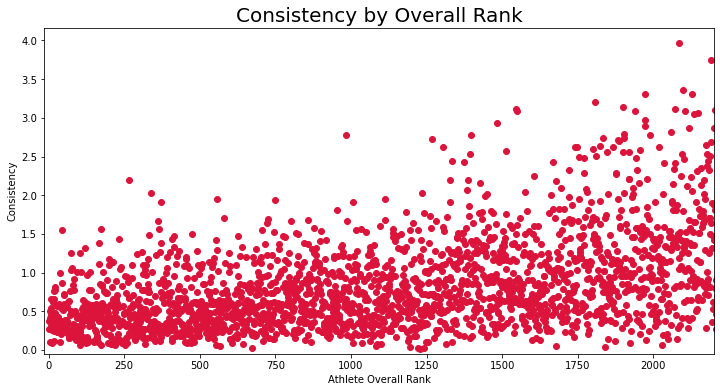

In [133]:
fig, ax = plt.subplots(1, figsize=(12,6))

ax.scatter('Overall Rank', 'Consistency', data=df, color = 'crimson')
ax.set_title('Consistency by Overall Rank', fontsize=20)
ax.set_xlabel('Athlete Overall Rank')
ax.set_ylabel('Consistency')
ax.set_xbound(-15, 2200)
ax.set_ybound(-.05)
plt.savefig('consistency.png')

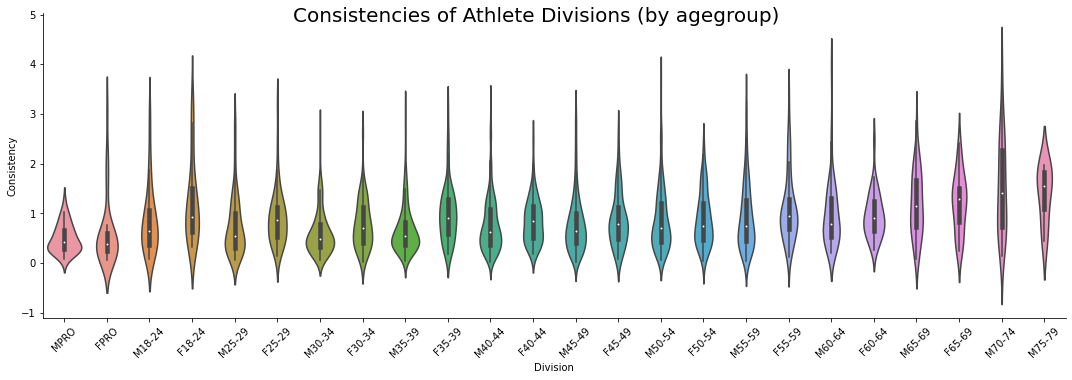

In [75]:
ax = sns.catplot(x='Division', y='Consistency',  kind='violin', split=True, data=df, 
                 order=['MPRO', 'FPRO', 'M18-24', 'F18-24', 'M25-29', 'F25-29', 'M30-34', 'F30-34', 'M35-39', 'F35-39', 'M40-44', 'F40-44',
                       'M45-49', 'F45-49', 'M50-54', 'F50-54', 'M55-59', 'F55-59', 'M60-64', 'F60-64', 'M65-69', 'F65-69', 'M70-74', 'M75-79'], height=5, aspect=3);
ax.set_xticklabels(rotation=45)
ax.fig.suptitle('Consistencies of Athlete Divisions (by agegroup)', fontsize=20)


# Using standardized event scores, let's explore a specialization metric:

compare consistency between disciplines : specialization metric

Running specialization = average of normalized (swim + bike) - normalized run.

So if a person has a low (fast) run, but a high (slow) swim and bike, their running specialization score would be high.

"is a running specialist more likely to finish in the top 20 of their division than a bike specialist?"

In [76]:
def specialize(row, discipline):
    '''
    Returns specialize metrics for events (swim, bike, or run)
    Users will need to edit the function to subtract whatever Specialized Metric they are looking for
    specialize('Swim')
    disciplines = [1, 2, 3]
    '''
    if discipline == 'Swim':
        other1 = 'Bike'
        other2 = 'Run'
    elif discipline == 'Bike':
        other1 = 'Swim'
        other2 = 'Run'
    else:
        other1 = 'Bike'
        other2 = 'Swim'
    return row[[f'Norm_{other1}', f'Norm_{other2}']].mean() - row[f'Norm_{discipline}']

In [77]:
for discipline in ['Swim', 'Bike', 'Run']:
    df[f'Specialize {discipline}'] = df.apply(specialize, args=(discipline,), axis=1)

In [73]:
df.drop(['Specialize Run', 'Specialize Swim', 'Specialize Bike'], axis=1, inplace=True)

In [78]:
df

,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,...,T1,T2,Norm_Swim,Norm_Bike,Norm_Run,Norm_T1,Norm_T2,Specialize Swim,Specialize Bike,Specialize Run
0,"Frodeno, Jan",DEU,Male,MPRO,47.516667,256.033333,162.716667,471.216667,1,1,...,1.966667,2.983333,-1.883184,-1.893678,-1.626397,-1.332243,-1.008652,0.123147,0.138887,-0.262034
1,"O'donnell, Tim",USA,Male,MPRO,47.633333,258.183333,169.750000,479.683333,2,2,...,2.016667,2.100000,-1.874301,-1.848245,-1.504890,-1.309350,-1.315450,0.197734,0.158649,-0.356383
2,"Kienle, Sebastian",DEU,Male,MPRO,52.283333,255.066667,169.933333,482.066667,3,3,...,2.200000,2.583333,-1.520258,-1.914105,-1.501723,-1.225408,-1.147579,-0.187656,0.403114,-0.215459
3,"Hoffman, Ben",USA,Male,MPRO,51.016667,264.016667,163.133333,482.866667,4,4,...,2.416667,2.283333,-1.616700,-1.724977,-1.619199,-1.126203,-1.251775,-0.055388,0.107027,-0.051640
4,"Wurf, Cameron",AUS,Male,MPRO,52.416667,254.733333,175.050000,486.683333,5,5,...,2.116667,2.366667,-1.510107,-1.921149,-1.413328,-1.263563,-1.222832,-0.157132,0.459431,-0.302299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,"Beavers, Cathy",USA,Female,F65-69,105.500000,505.016667,378.866667,1010.050000,26,609,...,10.416667,10.250000,2.531568,3.367750,2.107774,2.536726,1.515199,0.206194,-1.048079,0.841885
2254,"Whitehouse, Paul",USA,Male,M70-74,126.016667,471.333333,389.566667,1010.066667,28,1654,...,11.816667,11.333333,4.093672,2.655966,2.292626,3.177738,1.891462,-1.619376,0.537183,1.082193
2255,"Svoboda-vasquez, Hanna",DEU,Female,F50-54,89.550000,496.450000,407.700000,1011.050000,66,610,...,9.783333,7.566667,1.317162,3.186722,2.605894,2.246744,0.583227,1.579146,-1.225194,-0.353952
2256,"Piasentini, Edgardo",ARG,Male,M65-69,102.450000,462.150000,433.816667,1013.350000,50,1655,...,6.283333,8.650000,2.299346,2.461907,3.057081,0.644213,0.959489,0.460148,0.216307,-0.676455


In [146]:
fem_results = df[df['Gender'] == 'Female']
fem_pro = fem_results[fem_results['Division'] == 'FPRO']
fem_agegroups = fem_results[fem_results['Division'] != 'FPRO']
male_results = df[df['Gender'] == 'Male']
male_pro = male_results[male_results['Division'] == 'MPRO']
male_agegroups = male_results[male_results['Division'] != 'MPRO']

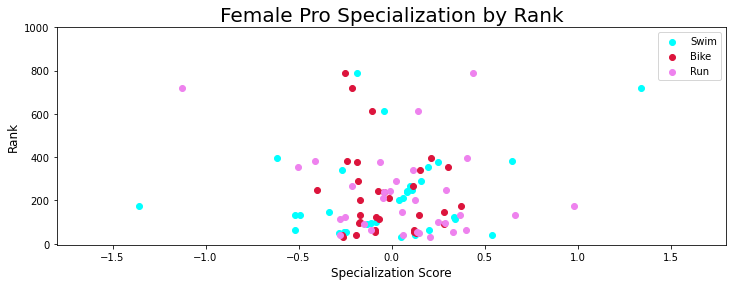

In [98]:
fig, ax = plt.subplots(1, figsize=(12,4))

ax.scatter(fem_pro['Specialize Swim'], fem_pro['Overall Rank'], color='aqua', label='Swim')
ax.scatter(fem_pro['Specialize Bike'], fem_pro['Overall Rank'], color='crimson', label='Bike')
ax.scatter(fem_pro['Specialize Run'], fem_pro['Overall Rank'], color='violet', label='Run')
ax.set_title('Female Pro Specialization by Rank', fontsize=20)
ax.set_xlabel('Specialization Score', fontsize=12)
ax.set_ylabel('Rank', fontsize=12)
ax.set_xbound(-1.8,)
ax.set_ybound(-5,1000)
ax.legend()


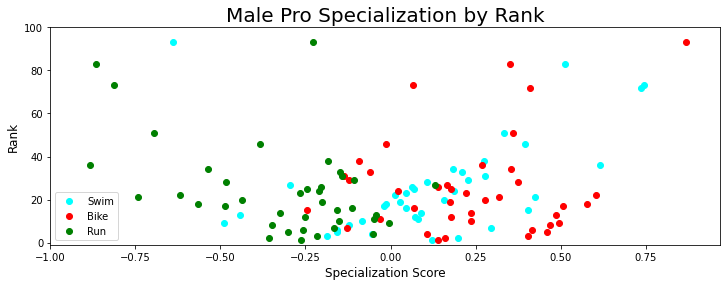

In [99]:
fig, ax = plt.subplots(1, figsize=(12,4))

ax.scatter(male_pro['Specialize Swim'], male_pro['Overall Rank'], color='aqua', label='Swim')
ax.scatter( male_pro['Specialize Bike'], male_pro['Overall Rank'],color='red', label='Bike')
ax.scatter( male_pro['Specialize Run'], male_pro['Overall Rank'],color='green', label='Run')
ax.set_title('Male Pro Specialization by Rank', fontsize=20)
ax.set_xlabel('Specialization Score', fontsize=12)
ax.set_ylabel('Rank', fontsize=12)
ax.set_xbound(-1,)
ax.set_ybound(-1, 100)
ax.legend()


Notes:
-min & max specialization
-consistency bounds
-how it's done at pro level - present alternative hypothesis for training
-plot specialization surface w/dimension == specialization


df's sort specialties by descending

cut them in half

randomly draw from specialty dfs and compare division rank

In [151]:
male_div_list = male_agegroups.Division.unique()
fem_div_list = fem_agegroups.Division.unique()
fem_div_list, male_div_list

(array(['F30-34', 'F25-29', 'F45-49', 'F50-54', 'F35-39', 'F40-44',
        'F18-24', 'F55-59', 'F60-64', 'F65-69', 'F70-74'], dtype=object),
 array(['M35-39', 'M30-34', 'M25-29', 'M45-49', 'M40-44', 'M18-24',
        'M50-54', 'M55-59', 'M60-64', 'M65-69', 'M70-74', 'M75-79',
        'M80-84'], dtype=object))

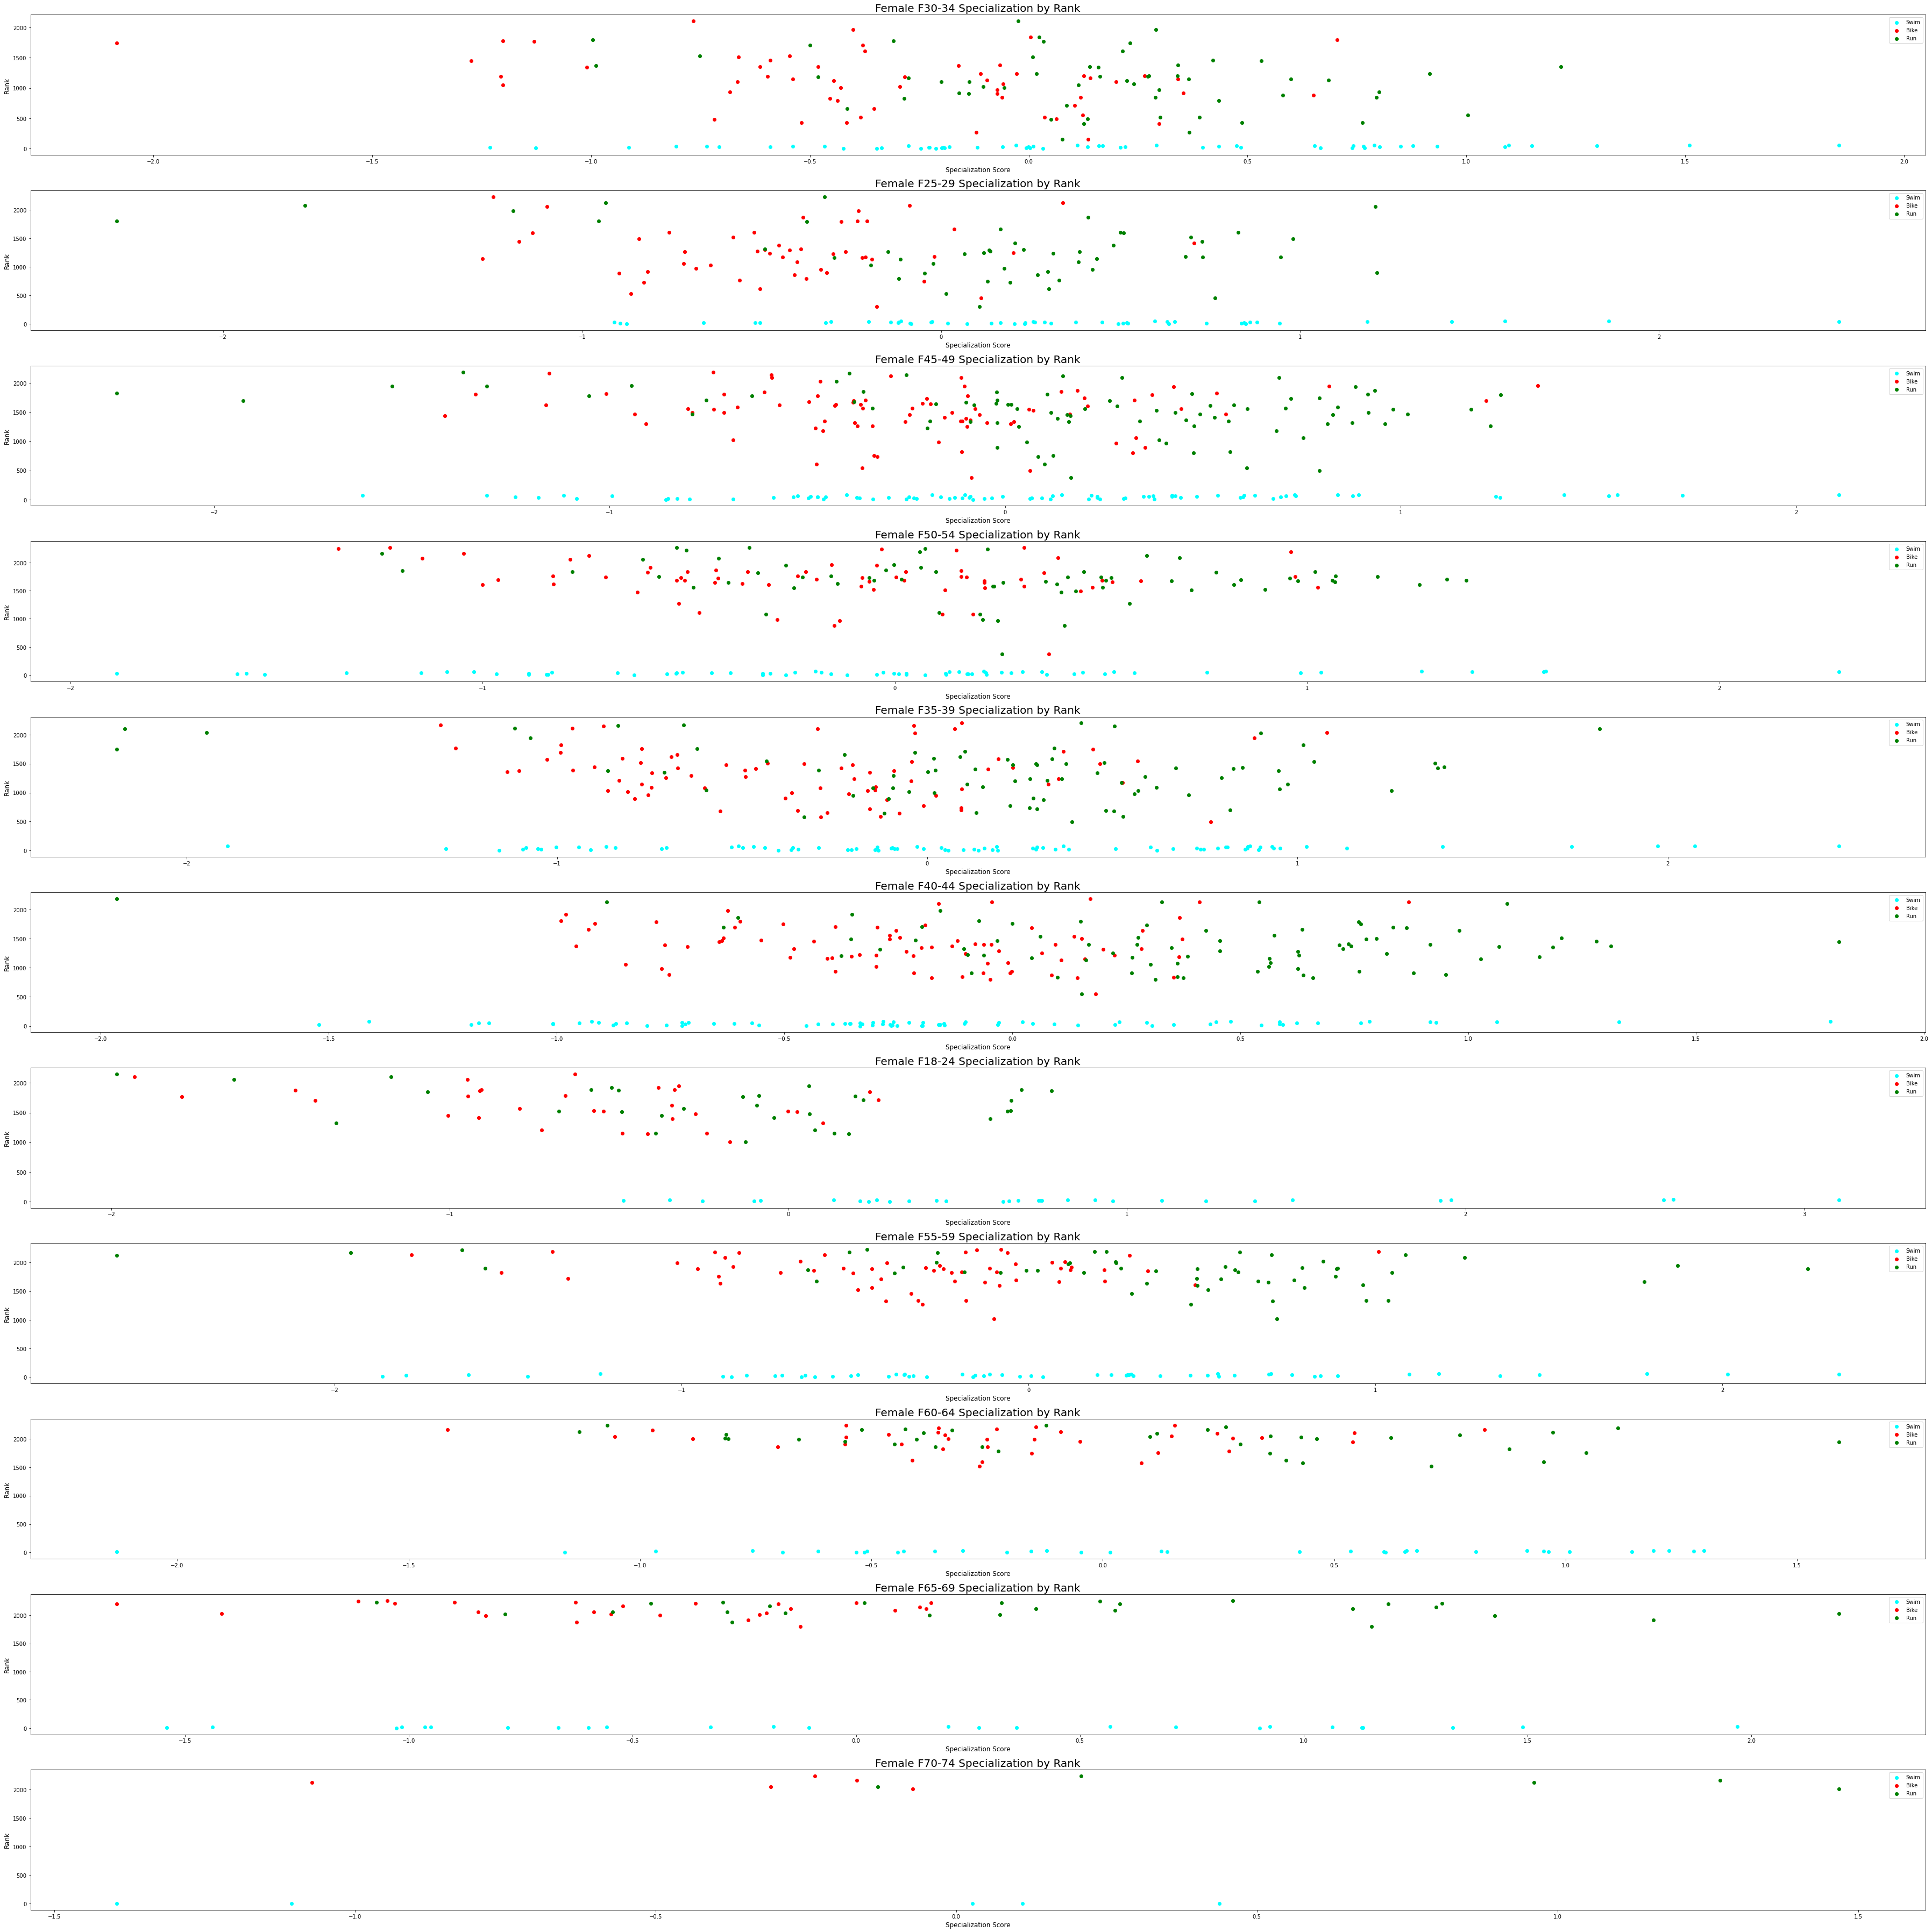

In [152]:
fig, ax = plt.subplots(len(fem_div_list), 1, figsize=(50,50))

for i, j in enumerate(fem_div_list):
    plot_df = fem_results[fem_results['Division'] == f'{j}']

    ax[i].scatter(plot_df['Specialize Swim'], plot_df['Division Rank'], color='aqua', label='Swim')
    ax[i].scatter(plot_df['Specialize Bike'], plot_df['Overall Rank'],color='red', label='Bike')
    ax[i].scatter(plot_df['Specialize Run'], plot_df['Overall Rank'],color='green', label='Run')
    ax[i].set_title(f'Female {j} Specialization by Rank', fontsize=20)
    ax[i].set_xlabel('Specialization Score', fontsize=12)
    ax[i].set_ylabel('Rank', fontsize=12)
    #ax[i].set_xbound(-1,)
    #ax[i].set_ybound(-1, 100)
    ax[i].legend()
plt.tight_layout()

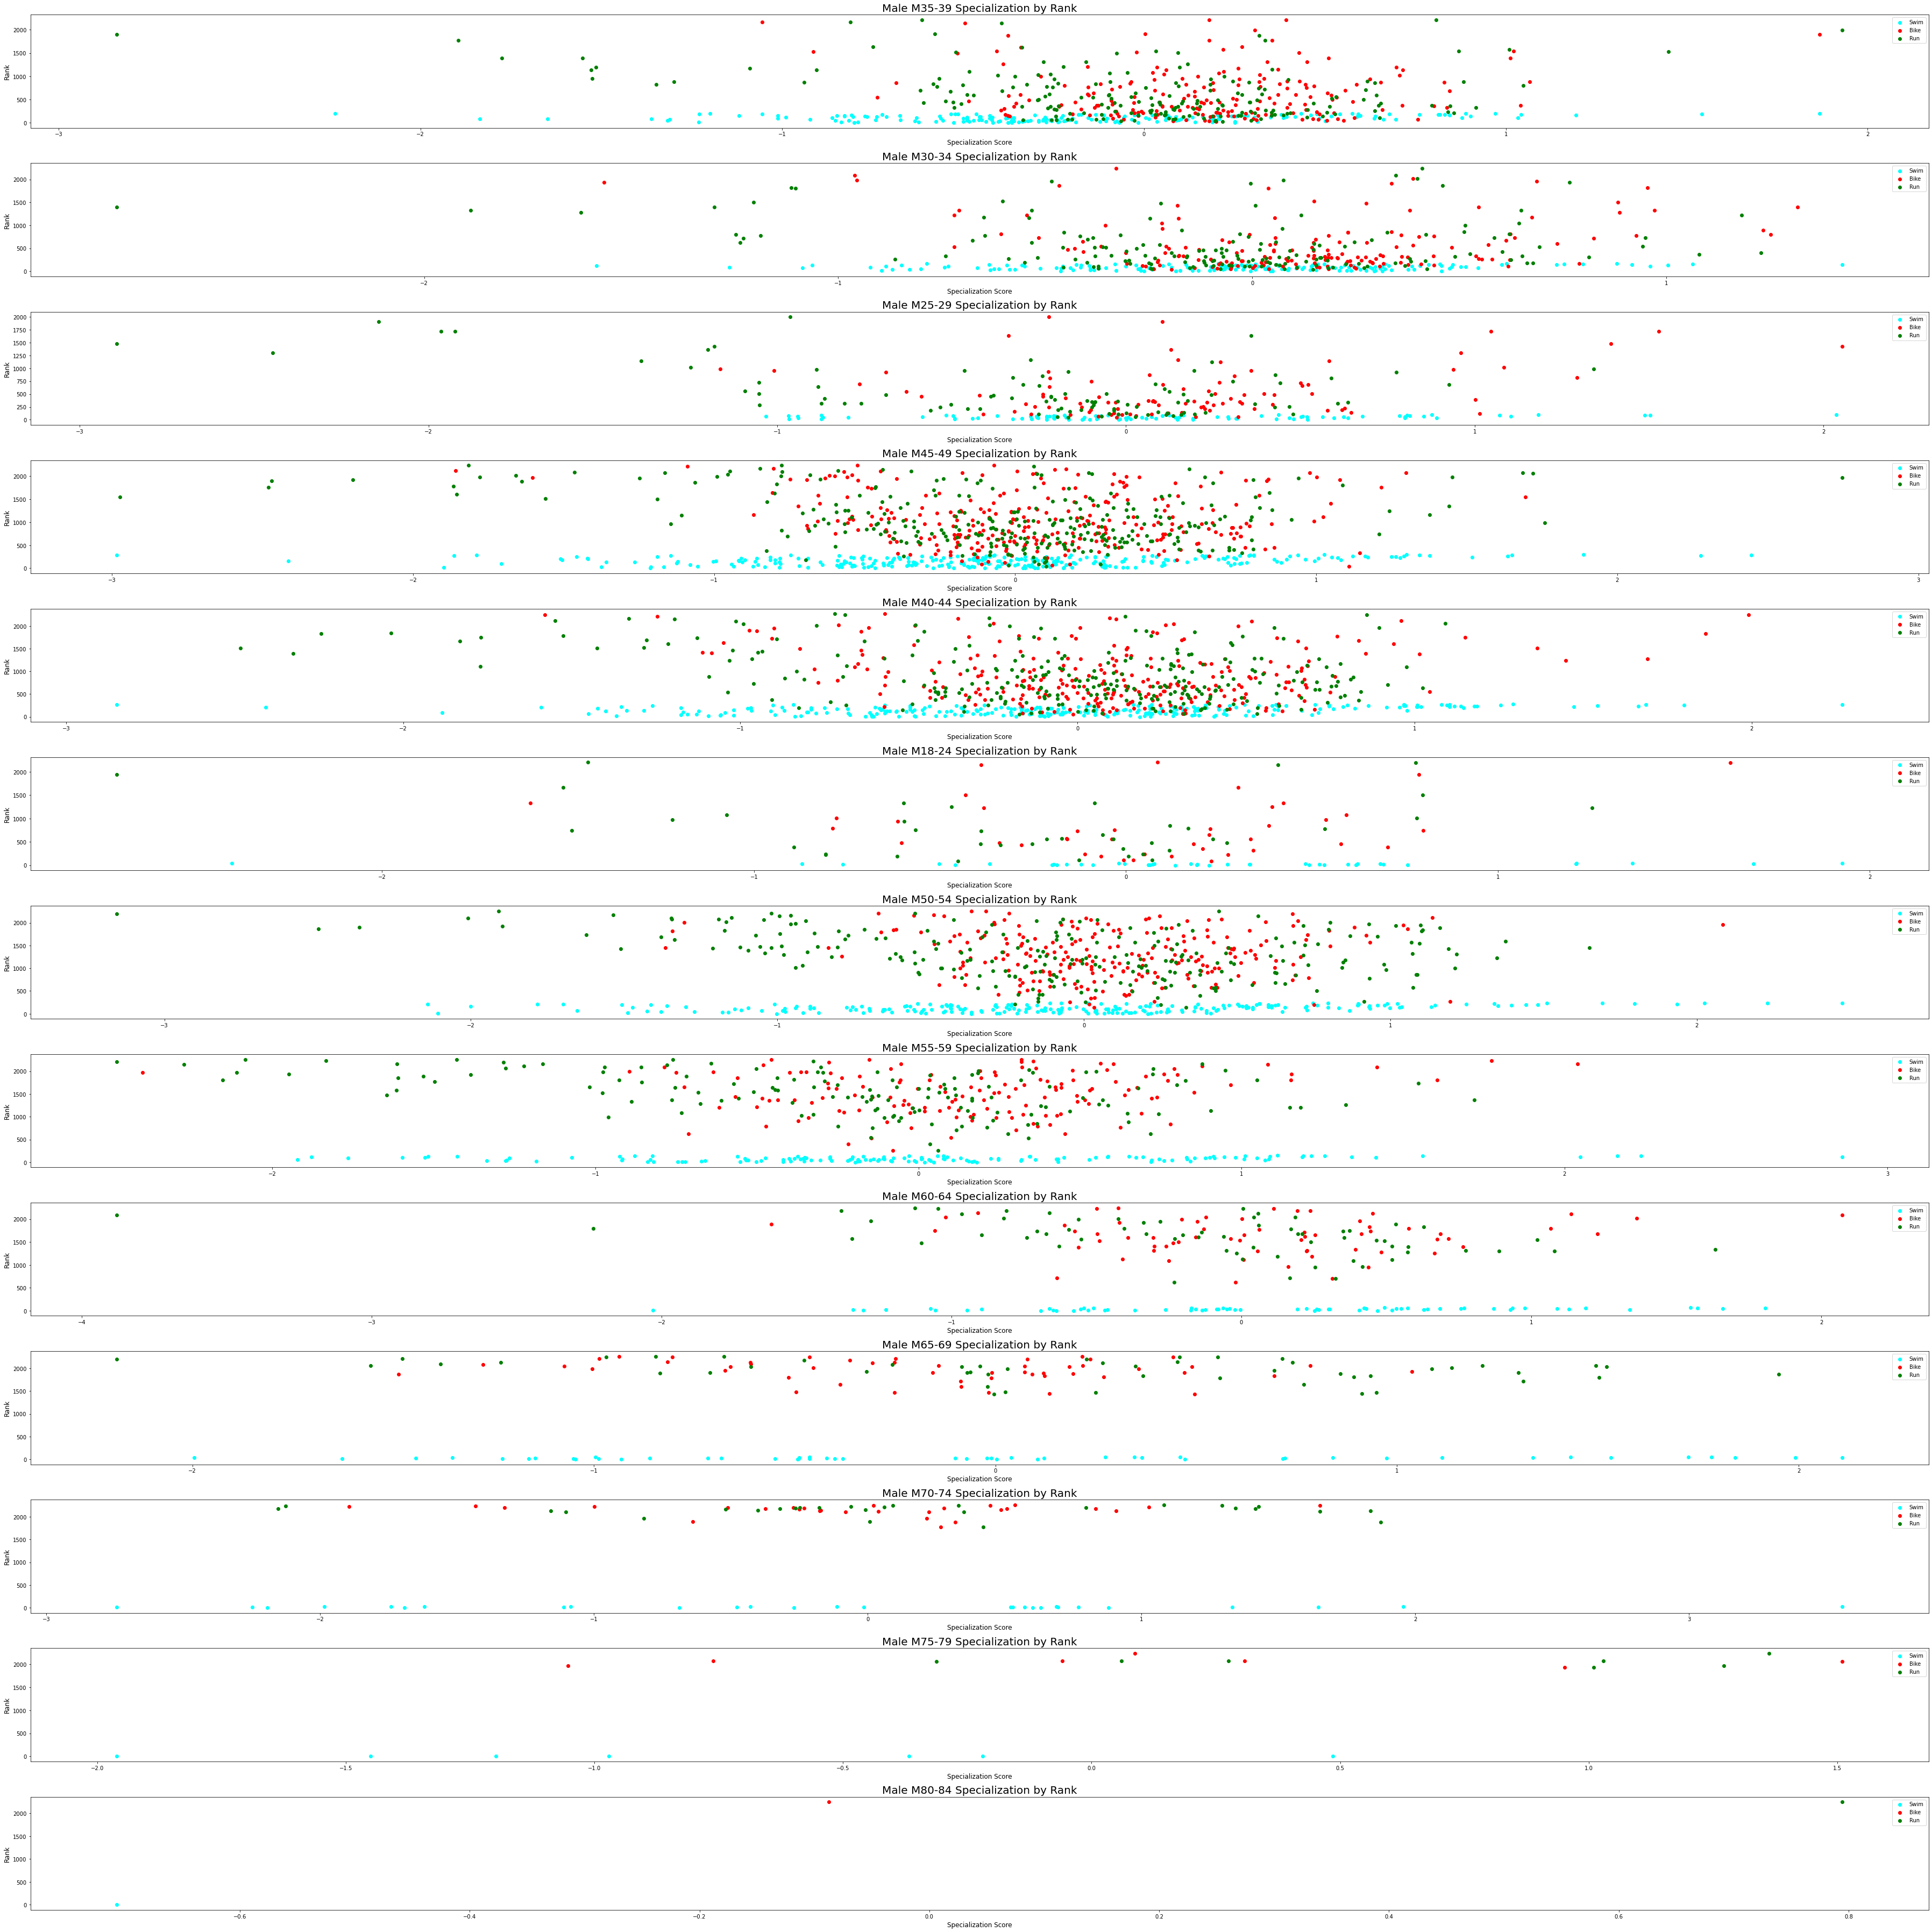

In [155]:
fig, ax = plt.subplots(len(male_div_list), 1, figsize=(50,50))

for i, j in enumerate(male_div_list):
    plot_df = male_results[male_results['Division'] == f'{j}']

    ax[i].scatter(plot_df['Specialize Swim'], plot_df['Division Rank'], color='aqua', label='Swim')
    ax[i].scatter(plot_df['Specialize Bike'], plot_df['Overall Rank'],color='red', label='Bike')
    ax[i].scatter(plot_df['Specialize Run'], plot_df['Overall Rank'],color='green', label='Run')
    ax[i].set_title(f'Male {j} Specialization by Rank', fontsize=20)
    ax[i].set_xlabel('Specialization Score', fontsize=12)
    ax[i].set_ylabel('Rank', fontsize=12)
    #ax[i].set_xbound(-1,)
    #ax[i].set_ybound(-1, 100)
    ax[i].legend()
plt.tight_layout()

In [167]:
df_spec_swim = df.sort_values('Specialize Swim')

In [169]:
df_spec_swim

,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,...,Bool_Gender,Norm_Swim,Norm_Bike,Norm_Run,Norm_T1,Norm_T2,Consistency,Specialize Run,Specialize Swim,Specialize Bike
263,"Kristensen, Lennie",DNK,Male,M50-54,84.783333,286.616667,195.483333,573.566667,5,241,...,False,0.954236,-1.247402,-1.060326,-0.614919,-0.950765,2.201638,0.767160,-3.261963,1.141312
1545,"Huse, Sue",CAN,Female,FPRO,111.033333,339.266667,251.833333,712.750000,35,312,...,True,2.952866,-0.134820,-0.086832,0.239764,-0.232973,3.087687,2.904878,-3.174519,3.000854
981,"Simkins, Russell",USA,Male,M45-49,95.783333,333.616667,199.550000,642.100000,155,872,...,False,1.791757,-0.254214,-0.990071,1.147865,-0.041947,2.781828,2.527614,-3.036042,1.055901
337,"Zieman, Chris",USA,Male,M45-49,82.950000,288.216667,201.683333,582.466667,20,311,...,False,0.814649,-1.213591,-0.953215,-0.157053,-0.279282,2.028240,0.554274,-2.981456,1.075025
1266,"Beck, Josh",USA,Male,M40-44,97.483333,307.266667,247.533333,671.916667,207,1071,...,False,1.921193,-0.811033,-0.161118,2.750397,0.994221,2.732226,1.271278,-2.893344,2.571107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,"Perrow, Leigh",AUS,Male,M55-59,78.050000,441.900000,449.100000,998.550000,145,1644,...,False,0.441572,2.033991,3.321114,2.048335,4.953657,2.879542,-0.845551,4.913533,1.728695
2249,"Kingsfield, Jeff",USA,Male,M50-54,78.850000,449.850000,445.700000,1008.516667,237,1653,...,False,0.502482,2.201988,3.262376,2.086491,6.528169,2.759894,-0.557906,4.961881,1.562871
2241,"Watkins, Kris",NZL,Male,M40-44,80.850000,498.033333,408.950000,1000.800000,273,1646,...,False,0.654759,3.220181,2.627489,0.186346,0.623747,2.565422,1.247451,5.192911,0.062067
2090,"Kurano, Mao",JPN,Female,F18-24,59.750000,459.433333,366.816667,899.916667,30,543,...,True,-0.951759,2.404499,1.899601,-0.195209,1.243133,3.356258,-0.446860,5.255859,-1.456658
